In [1]:
import napari
from pathlib import Path
import numpy as np
import skimage
from napari_morphodynamics.napari_gui import MorphoWidget
from napari.utils import nbscreenshot

In [2]:
viewer = napari.Viewer()
widget = MorphoWidget(viewer)
viewer.window.add_dock_widget(widget)

# Data



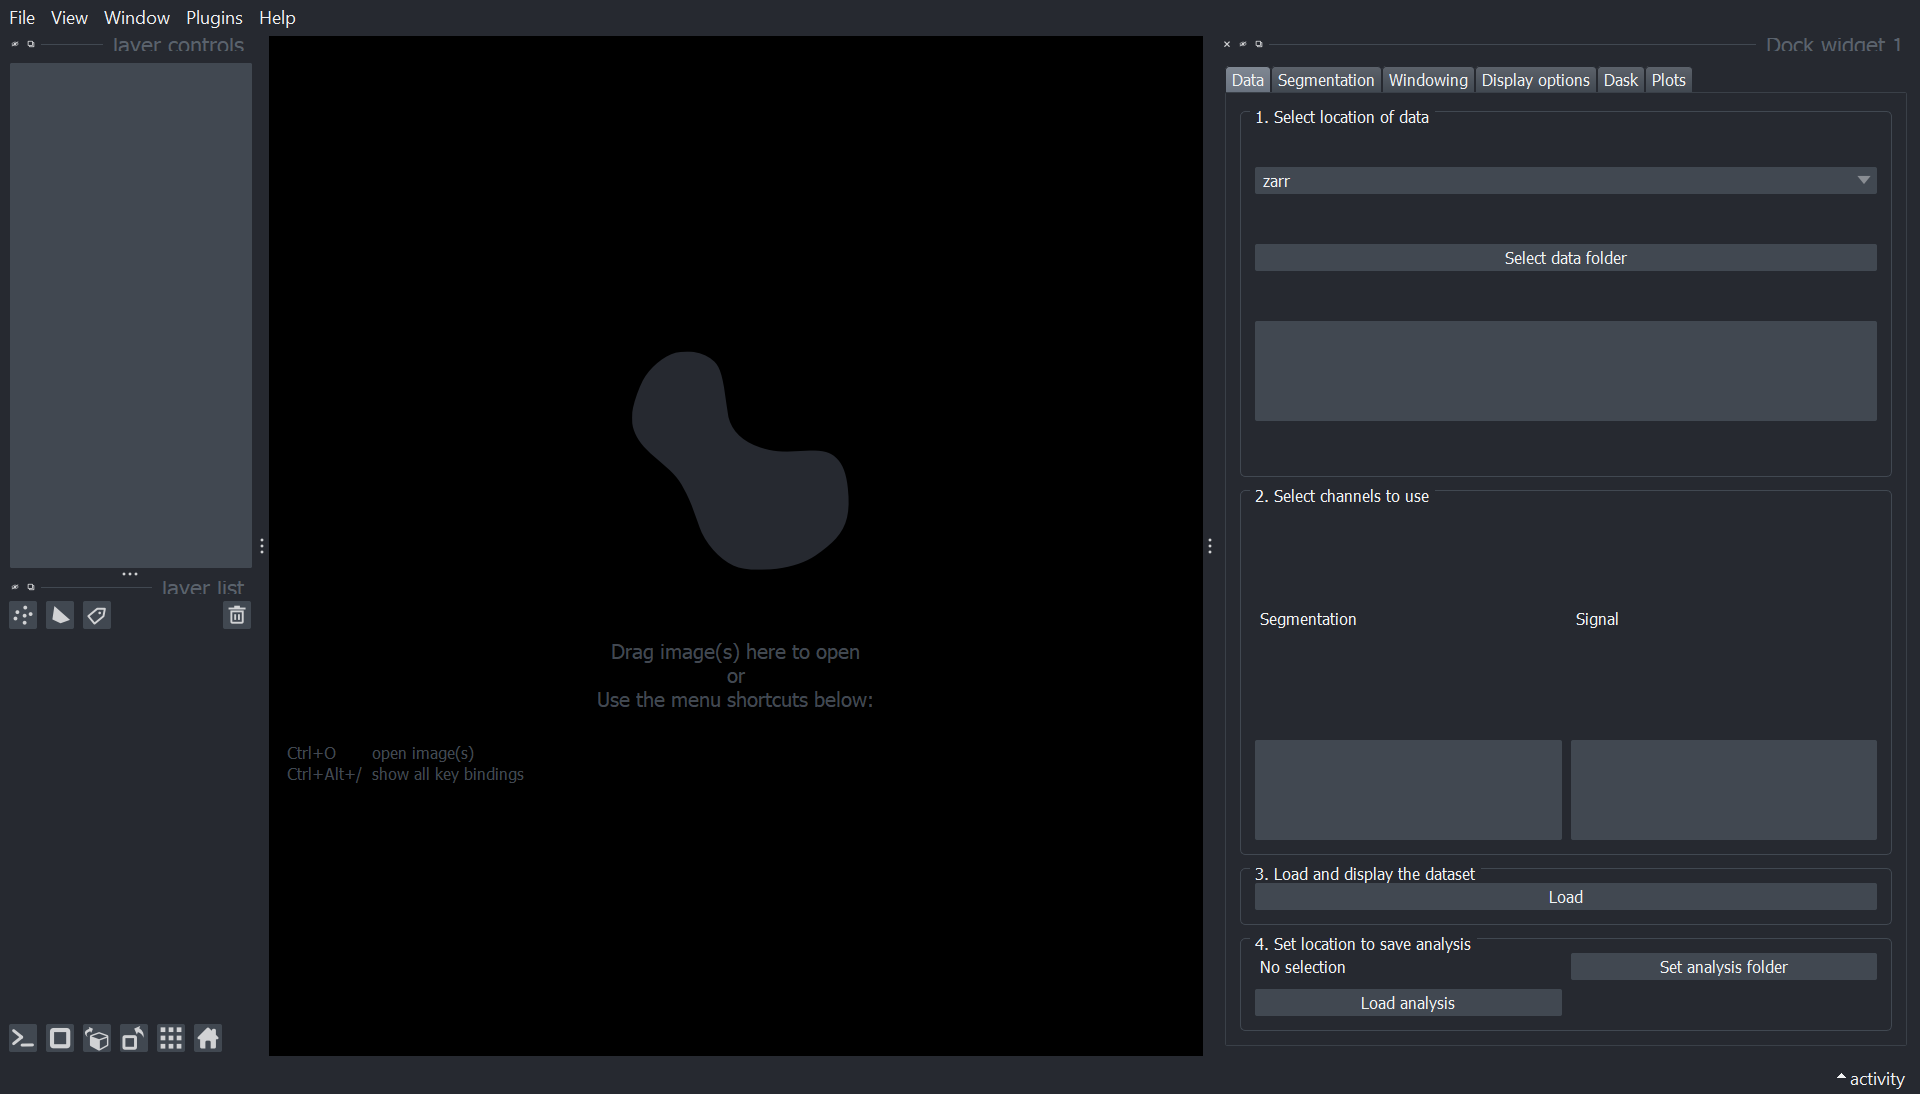

In [4]:
nbscreenshot(viewer)